Non Linear fitting - second version

* Instead of simulating each step of random walk I took a random variable with binomial distribution for produce a sample of $S_n$ (this makes the simulation way faster, simulate each step of random walk for $k\leq 16$ and numbsimul = 3200 takes about one minute, simulate using binomial sample for $k \leq 31$ and numbsimul = 1.600.000 takes 13 seconds).
* Taking a nonlinear fitting of the form $f(k) = a + b*k + c*\exp(-d*k)$ and use minimum squares to estimateparameters $a,b,c,d$
* Ignoring small boxes ($8\leq k \leq 31$)

* Compare non-linear with linear all dots, and (...)
* (to do) compare with linear aproximation using only two dots ($n, \sqrt{n}$).
* (to do) Do my own version of random.binomial that can sample binom(n,0.5), for $n$ bigger than $2^{31}$.



Conclusions

Non linear fitting works as well as linear fitting for $8 \leq k \leq 31$, but for others intervals of $k$ non-linear fitting works worse (maybe I am not choosing the correct error decay $c*\exp(-d*k)$).



-----------------------Non-linear approximation-------------------------------------
----- diffusion constant is approximally 0.5008832196420567 using quantile 0.45 ----
------------------------------------------------------------------------------------
---------- f(k) = -0.762 + 0.501*k + 0.225 * exp( -5.75*k) -----------------------
------------------------------------------------------------------------------------
---------------------------Linear approximation-------------------------------------
----- diffusion constant is approximally 0.5008835468147005 using quantile 0.45 -----
------------------------------------------------------------------------------------


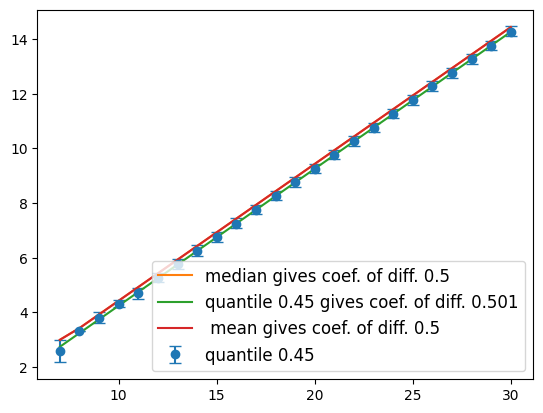

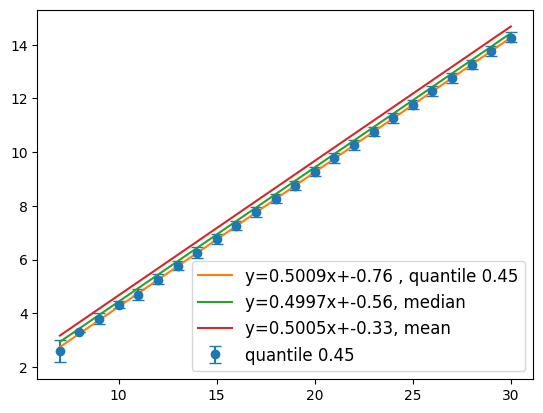

-----------------------Non-linear approximation-------------------------------------
----- diffusion constant is approximally 0.5004033875848305 using quantile 0.5 ----
------------------------------------------------------------------------------------
---------- f(k) = -0.574 + 0.5*k + 1.55e+15 * exp( -5.37*k) -----------------------
------------------------------------------------------------------------------------
---------------------------Linear approximation-------------------------------------
----- diffusion constant is approximally 0.4996899250674947 using quantile 0.5 -----
------------------------------------------------------------------------------------


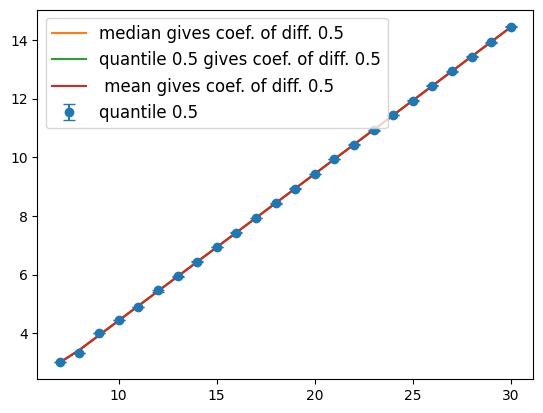

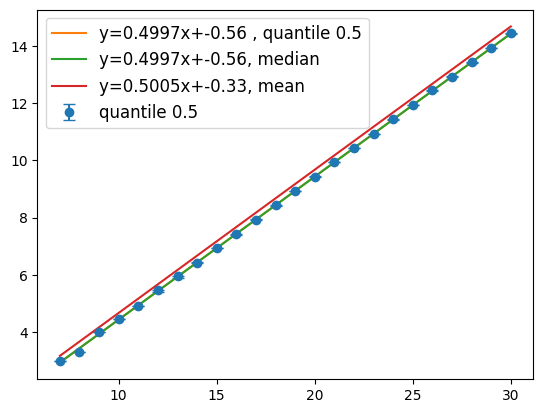

-----------------------Non-linear approximation-------------------------------------
----- diffusion constant is approximally 0.5007847975858225 using quantile 0.55 ----
------------------------------------------------------------------------------------
---------- f(k) = -0.421 + 0.501*k + -0.051 * exp( -6.21*k) -----------------------
------------------------------------------------------------------------------------
---------------------------Linear approximation-------------------------------------
----- diffusion constant is approximally 0.5007848013398837 using quantile 0.55 -----
------------------------------------------------------------------------------------


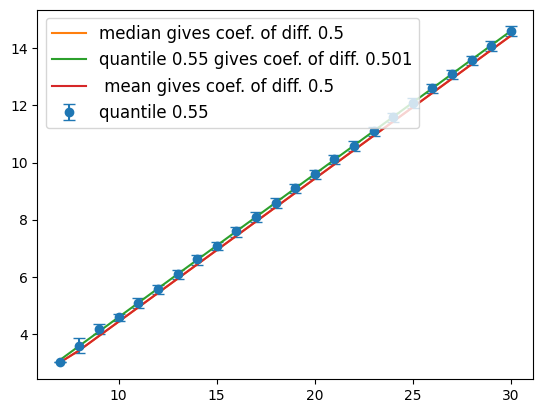

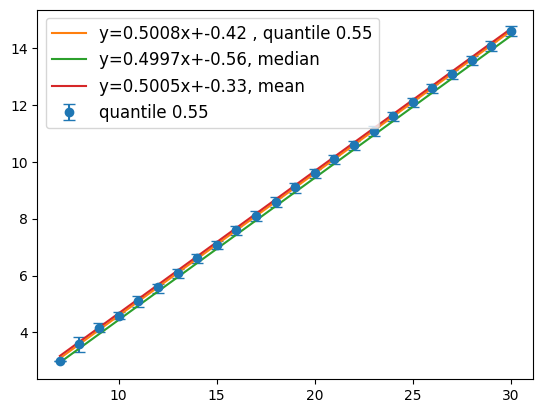

--- 5.790331125259399 seconds ---


In [19]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import math
import numpy as np
from scipy.stats import norm
import statistics 
import time
from scipy.optimize import least_squares # for nonlinear regression usinf min squares
# seed the pseudorandom number generator
from random import seed
from random import random
seed(2001) # seed random number generator
start_time = time.time()

point1 = 16
point2 = 31
start = 7

numbsimul = 160000
Size = np.linspace(start, point2-1, point2-start)

A = np.zeros((point2 - start,numbsimul))

# simulations of random walks
for k in range(start,point2):
    n=pow(2,k)
    A[k-start] = 2*np.random.binomial(n,0.5,numbsimul) - n


# define the matrix A_two that contains only samples of box of size point1 and point2
point1_samples = A[point1-start, :].reshape(-1, 1)
point2_samples = A[-1, :].reshape(-1, 1)
A_two = np.hstack((point1_samples, point2_samples))

# taking absolute value of S_n, sorting the samples, calculate mean and median.
def treat_this_data(A):
    absA = np.abs(A)
    sortedAbs = np.sort(absA)
    meanA = absA.mean(1)
    median = np.quantile(absA, 0.5 , 1)
    return (absA,sortedAbs,meanA, median)

# calculating the interval of confidence
alpha = 0.001 # confidence level

def confidence_level(logq, point2, sortedAbs):
    lowerboundindex = [math.floor(0.5*(numbsimul - math.sqrt(numbsimul)*norm.isf(alpha))) for i in range(point2)]
    upperboundindex = [math.ceil(0.5*(numbsimul + math.sqrt(numbsimul)*norm.isf(alpha))) for i in range(point2)]
    
    lowerboundheight = sortedAbs[np.arange(point2),lowerboundindex]
    upperboundheight = sortedAbs[np.arange(point2),upperboundindex]
    loglower = np.log(lowerboundheight)/np.log(2)
    logupper = np.log(upperboundheight)/np.log(2)

    errorbar = [np.abs(loglower-logq), np.abs(logupper-logq)]
    return errorbar


# fit_func (k) = a * k + b + c * exp ( -d * k )
def fit_func(param,k):
    return param[0]*k + param[1] + param[2]*np.exp(-param[3]*k )
# cost function for minimum squares
def cost(param, k , data):
    return fit_func(param,k) - data

param = np.array([1,1,1,1])


def regression(q, Size, A):
    B = treat_this_data(A)
    absA = B[0]
    sortedAbs = B[1]
    meanA = B[2]
    median = B[3]
    
    quantile = np.quantile(absA, q, 1)

    logquantile = np.log(quantile)/np.log(2)
    logmean = np.log(meanA)/np.log(2)
    logmedian = np.log(median)/np.log(2)

    if len(Size) > 2:
        # non linear regression
        func = least_squares(cost, param, args=(Size,logquantile))
        pmean = least_squares(cost, param, args=(Size,logmean))
        pmedian = least_squares(cost, param, args=(Size,logmedian))

    # linear regression 
    linear = np.polyfit(Size, logquantile, 1)
    linearmean = np.polyfit(Size, logmean, 1)
    linearmedian = np.polyfit(Size, logmedian, 1)
    if len(Size)>2:
        print("-----------------------Non-linear approximation-------------------------------------")
        print("----- diffusion constant is approximally %s using quantile %s ----" % (func.x[0],q))
        print("------------------------------------------------------------------------------------")
        print("---------- f(k) = {:.3} + {:.3}*k + {:.3} * exp( -{:.3}*k) -----------------------".format(func.x[1], func.x[0], func.x[2], func.x[3]))
        print("------------------------------------------------------------------------------------")

    print("---------------------------Linear approximation-------------------------------------")
    print("----- diffusion constant is approximally %s using quantile %s -----" % (linear[0],q))
    print("------------------------------------------------------------------------------------")
    
    if len(Size)>2:
        # Print non-linear graphics
        errorbar = confidence_level(logquantile, len(Size), sortedAbs)
        plt.errorbar(Size,logquantile,yerr=errorbar,linestyle = 'None', label = 'quantile {:.2}'.format(q),capsize=4, marker = 'o')
        plt.plot(Size, fit_func(pmedian.x,Size), label='median gives coef. of diff. {:.3}'.format(pmedian.x[0]))
        plt.plot(Size, fit_func(func.x,Size), label='quantile {:.2} gives coef. of diff. {:.3}'.format(q,func.x[0]))
        plt.plot(Size, fit_func(pmedian.x,Size), label=' mean gives coef. of diff. {:.3}'.format(pmean.x[0]))

        plt.legend(fontsize=12)
        plt.show()  

    # Printing linear graphics
    plt.errorbar(Size,logquantile,yerr=errorbar, linestyle = 'None',label = 'quantile {:.2}'.format(q),capsize=4, marker = 'o')
    plt.plot(Size, linear[1]+linear[0]*Size, label='y={:.4}x+{:.2} , quantile {:.2}'.format(linear[0],linear[1], q))
    plt.plot(Size, linearmedian[1]+linearmedian[0]*Size, label='y={:.4}x+{:.2}, median'.format(linearmedian[0],linearmedian[1]))
    plt.plot(Size, linearmean[1]+linearmean[0]*Size, label='y={:.4}x+{:.2}, mean'.format(linearmean[0],linearmean[1]))

    plt.legend(fontsize=12)
    plt.show()  

# regression 
regression(0.45, Size, A)
regression(0.5 , Size, A)
regression(0.55, Size, A)

print("--- %s seconds ---" % (time.time() - start_time))